In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm
from itertools import chain, combinations, product

In [4]:
C = [('red', 'one'),
     ('blue', 'one'),
     ('red', 'two')]
U = ['red', 'blue', 'one', 'two']
P = np.array([1. / 3.] * 3)
M = np.zeros((len(U), len(C)))

# inverse temperature; how rational speaker is
alpha = 1.
# utterance cost function
kappa = np.array([0., 0., 0.])

# configure meaning function
for i, u in enumerate(U):
    for j, t in enumerate(C):
        M[i,j] = 1. if u in t else 0.

In [5]:
##### Listener Model ######
# literal listener
L_0 = M * P

# pragmatic speaker
S_1 = np.exp(alpha * (np.log(L_0) - kappa))

# pragmatic listener
L_2 = S_1 * P

/Users/mwalton/miniconda3/envs/plot/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


assuming constant alpha = 1, kappa = 0 for all u

In [6]:
# Pragmatic Speaker
S_0 = M / np.sum(M, axis=0, keepdims=True)
L_1 = S_0 / np.sum(S_0, axis=1, keepdims=True)
S_2 = L_1 / np.sum(L_1, axis=0, keepdims=True)

# Pragmatic Listener
L_0 =  M / np.sum(M, axis=1, keepdims=True)
S_1 = L_0 / np.sum(L_0, axis=0, keepdims=True)
L_2 = S_1 / np.sum(S_1, axis=1, keepdims=True)

S_2

array([[0.5       , 0.        , 0.33333333],
       [0.        , 0.66666667, 0.        ],
       [0.5       , 0.33333333, 0.        ],
       [0.        , 0.        , 0.66666667]])

# Hanabi RSA

In [204]:
class HanabiDeck(object):
    def __init__(self):
        self.n = 50
        self.F = ('r', 'g', 'b', 'w', 'y')
        self.V = (1, 2, 3, 4, 5)
        self.nu = {1: 3, 2: 2, 3: 2, 4: 2, 5: 1}
#         self.nu = {1: 2, 2: 2, 3: 2, 4: 2, 5: 2}
        self.ids, self.counts = self._init_counts()
        self.num_cards = 5
        self.color_to_ind = {'r': 0, 'g': 1, 'b':2, 'w':3, 'y':4}

    def _init_counts(self):
        p = []
        ids = []

        for i, c in enumerate(self.F):
            for j, v in enumerate(self.V):
                multiplicity = self.nu[v]
                p.append(multiplicity)
                ids.append(c + str(v))
        return ids, np.array(p)

    def sample(self, num_cards=5):
        p = self.p()
        hand = []
        for _ in range(num_cards):
            hand.append(np.random.choice(self.ids, p=p[:(len(self.F) * len(self.V))]))
        return np.array(hand)

    def p(self):
        p = self.counts / np.sum(self.counts)
        return p

    def meaning_function(self):
        num_hints = (len(self.F) + len(self.V))
        num_cards_in_hand = self.num_cards
        num_unique_cards = len(self.F) * len(self.V)
        M = np.zeros((num_hints, num_unique_cards, num_cards_in_hand))
        for hint_ind, hint in enumerate(self.F + self.V):
            for i in range(5):
                if type(hint) == str:
                    M[hint_ind, (5 * self.color_to_ind[hint]) + i] = 1
                else:
                    M[hint_ind, (5 * i) + hint - 1] = 1
        return M

    def powerset(self, set_in):
        s = list(set_in)
        res_list = list(chain.from_iterable(combinations(s, r) for r in range(len(s) + 1)))
        return res_list[1:] if len(res_list) > 0 else []


def pragmatic_agent(M, P, k, type):
    if type == 'listener':
        norm = [1, 0]
    elif type == 'speaker':
        norm = [0, 1]
    else:
        raise ValueError("No such agent type")

    accs = []

    psi = M * P
    for i in range(1, k + 1):
        listener_role = psi / np.sum(psi, axis=norm[0], keepdims=True)
        speaker_role = listener_role / np.sum(listener_role, axis=norm[1], keepdims=True)
        #accs.append(np.mean([np.trace(np.matmul(listener_role[:,:,j].T, speaker_role[:,:,j])) / M.shape[1] for j in range(M.shape[-1])]))
        hand_acc = []
        for j in range(M.shape[-1]):
            diag = np.diag(np.matmul(listener_role[:,:,j].T, speaker_role[:,:,j]))
            #print(diag)
            hand_acc.append(np.sum(np.multiply(np.squeeze(P), diag)))
        print(hand_acc)
        accs.append(np.mean(hand_acc))

        psi = speaker_role

    return psi, accs

In [205]:
deck = HanabiDeck()
hand = deck.sample()
print("example hand: {}".format(hand))

example hand: ['y3' 'r3' 'w4' 'b3' 'y3']


In [206]:
M = deck.meaning_function()
P = np.reshape(deck.p(), (1,25,1))
L, acc_l = pragmatic_agent(M, P, 20, 'listener')
S, acc_s = pragmatic_agent(M, P, 20, 'speaker')

[0.21466666666666667, 0.21466666666666667, 0.21466666666666667, 0.21466666666666667, 0.21466666666666667]
[0.20681945117468495, 0.20681945117468495, 0.20681945117468495, 0.20681945117468495, 0.20681945117468495]
[0.2033137857801633, 0.2033137857801633, 0.2033137857801633, 0.2033137857801633, 0.2033137857801633]
[0.20163203912744707, 0.20163203912744707, 0.20163203912744707, 0.20163203912744707, 0.20163203912744707]
[0.20080914932904864, 0.20080914932904864, 0.20080914932904864, 0.20080914932904864, 0.20080914932904864]
[0.2004027296574831, 0.2004027296574831, 0.2004027296574831, 0.2004027296574831, 0.2004027296574831]
[0.20020088439639347, 0.20020088439639347, 0.20020088439639347, 0.20020088439639347, 0.20020088439639347]
[0.20010031947540838, 0.20010031947540838, 0.20010031947540838, 0.20010031947540838, 0.20010031947540838]
[0.20005012871614514, 0.20005012871614514, 0.20005012871614514, 0.20005012871614514, 0.20005012871614514]
[0.20002505655918423, 0.20002505655918423, 0.20002505655

Text(0.5, 0, 'Recursion depth')

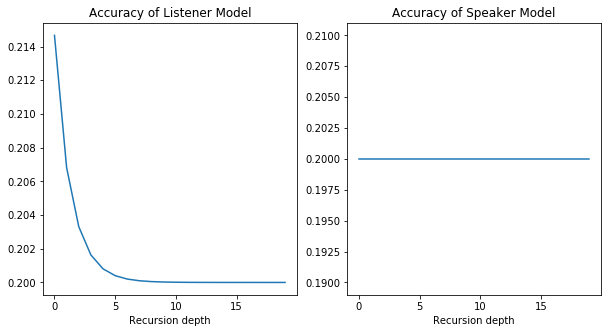

In [207]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(acc_l)
ax[0].set_title("Accuracy of Listener Model")
ax[0].set_xlabel("Recursion depth")
ax[1].plot(acc_s)
ax[1].set_title("Accuracy of Speaker Model")
ax[1].set_xlabel("Recursion depth")

In [88]:
M = deck.meaning_function()
P = np.reshape(deck.p(), (1,25,1))
mp = np.multiply(M, P)
pd.DataFrame(mp[:,:,0])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.06,0.04,0.04,0.04,0.02,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.06,0.04,0.04,0.04,0.02,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.06,0.04,0.04,0.04,0.02,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.06,0.04,0.04,0.04,0.02
5,0.06,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,...,0.06,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00
6,0.00,0.04,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,...,0.00,0.04,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00
7,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.04,0.00,0.00,...,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.04,0.00,0.00
8,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.04,0.00,...,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.04,0.00
9,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.02,...,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.02


In [190]:
np.sum(P)

1.0